In [ ]:
!pip install autogluon.tabular dalex shap

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import dalex as dx # for explanations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [ ]:


# Unzip the file
with zipfile.ZipFile('/content/project_2_training.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('')

# Load the dataset
df = pd.read_csv('project_2_training.csv').sample(10000) # sample it to speed things up!

# Display the first few rows of the dataframe
df.head()


,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,...,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
45581,1275240,4695.0,2677.0,51.0,3806.0,194.114.200.139,Mozilla/5.0 (Windows 98; wa-BE; rv:1.9.2.20) G...,thornton-contreras.com,092.555.2280x15108,Leonardborough,...,W,2021-03-08 05:44:40,Christy Perry,6511 Richards Street,866-22-8536,mag_IN,H,40.0,6991.0,legit
34400,1857580,4816.0,3162.0,58.0,2612.0,216.255.74.168,Opera/8.63.(X11; Linux i686; fo-FO) Presto/2.9...,castaneda-fields.com,(472)939-7370x965,North Douglasborough,...,D,2021-06-09 20:19:28,Russell Cowan,38891 Stuart Lock,175-93-3845,xh_ZA,E,56.0,12127.0,legit
47693,1194240,3642.0,1497.0,59.0,3705.0,162.22.215.199,Opera/9.38.(Windows NT 4.0; ff-SN) Presto/2.9....,lucero.net,0041145040,South Davidberg,...,G,2021-08-17 06:35:14,Mark Bradley,884 Walsh Field Apt. 590,560-19-4776,ayc_PE,L,30.0,2464.0,legit
41962,2955740,3556.0,1704.0,60.0,5728.0,5.192.250.48,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_1 like M...,porter-morgan.com,918-770-0895,Jeremiahbury,...,X,2021-06-26 13:06:26,Timothy May,68477 Davis Well Apt. 554,367-55-1143,az_IN,J,2.0,5306.0,legit
86689,752500,3693.0,1406.0,54.0,3537.0,208.62.164.226,Mozilla/5.0 (Windows NT 5.01) AppleWebKit/533....,lopez-white.info,+1-755-646-9834,Fisherchester,...,W,2021-04-07 01:37:21,Vanessa Schultz,932 Ray Centers,331-29-1493,ks_IN,G,100.0,11540.0,legit


In [ ]:
df['EVENT_LABEL'] = df['EVENT_LABEL'].map({'legit': 0, 'fraud': 1})
df['EVENT_LABEL'].value_counts()

EVENT_LABEL
0    9490
1     510
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test
train_data, test_data,  = train_test_split(df, test_size=0.3, random_state=42)
print(f"X_train: {train_data.shape}")
print(f"X_test: {test_data.shape}")


X_train: (7000, 27)
X_test: (3000, 27)


In [ ]:
time_limit = 360           # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'roc_auc'        # specify your evaluation metric here

# Columns to exclude
#ignored_columns = ['EVENT_ID','EVENT_TIMESTAMP' ]
#train_data.drop(columns=ignored_columns, inplace=True)
#test_data.drop(columns=ignored_columns, inplace=True)

# Initialize the TabularPredictor object.
glu_model = TabularPredictor(label='EVENT_LABEL',
                             problem_type='binary',
                             eval_metric=metric)


# Fit the model.
"""
presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
"""
glu_model = glu_model.fit(train_data,
                          time_limit=time_limit,
                          presets='medium_quality', # switch to one of the above presets.
                          )

No path specified. Models will be saved in: "AutogluonModels/ag-20240713_165550"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.41 GB / 12.67 GB (90.0%)
Disk Space Avail:   198.33 GB / 225.83 GB (87.8%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "AutogluonModels/ag-20240713_165550"
Train Data Rows:    7000
Train Data Columns: 26
Label Column:       EVENT_LABEL
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11693.62 MB
	Train Data (Original)  Memory Usage: 8.57 MB

In [ ]:
glu_model.evaluate(test_data)

{'roc_auc': 0.9127773416269098,
 'accuracy': 0.966,
 'balanced_accuracy': 0.6613684401231958,
 'mcc': 0.5354429190655016,
 'f1': 0.47959183673469385,
 'precision': 0.9215686274509803,
 'recall': 0.32413793103448274}

In [ ]:
glu_model.leaderboard(test_data)


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.930969,0.926832,roc_auc,0.091359,0.022451,3.959156,0.091359,0.022451,3.959156,1,True,3
1,WeightedEnsemble_L2,0.912777,0.951180,roc_auc,0.873211,0.225806,48.138241,0.009450,0.000726,0.117541,2,True,13
2,XGBoost,0.911542,0.941349,roc_auc,0.149718,0.028189,12.381537,0.149718,0.028189,12.381537,1,True,10
3,NeuralNetTorch,0.897305,0.926037,roc_auc,0.095689,0.033833,20.565351,0.095689,0.033833,20.565351,1,True,11
4,RandomForestEntr,0.892632,0.899808,roc_auc,0.343291,0.103848,5.031385,0.343291,0.103848,5.031385,1,True,6
5,LightGBM,0.889787,0.921289,roc_auc,0.058962,0.017403,2.520851,0.058962,0.017403,2.520851,1,True,4
6,RandomForestGini,0.881672,0.888366,roc_auc,0.374914,0.104644,7.545725,0.374914,0.104644,7.545725,1,True,5
7,LightGBMLarge,0.881004,0.941683,roc_auc,0.092196,0.020066,5.575030,0.092196,0.020066,5.575030,1,True,12
8,NeuralNetFastAI,0.833491,0.820365,roc_auc,0.190973,0.048793,16.951613,0.190973,0.048793,16.951613,1,True,9
9,ExtraTreesEntr,0.820411,0.808066,roc_auc,0.453647,0.125397,4.923466,0.453647,0.125397,4.923466,1,True,8


In [ ]:
glu_model.leaderboard(test_data, extra_metrics=['accuracy', 'f1', 'balanced_accuracy', 'log_loss'])


,model,score_test,accuracy,f1,balanced_accuracy,log_loss,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.930969,0.971333,0.594340,0.716541,-0.096092,0.926832,roc_auc,0.061812,0.022451,3.959156,0.061812,0.022451,3.959156,1,True,3
1,WeightedEnsemble_L2,0.912777,0.966000,0.479592,0.661368,-0.108336,0.951180,roc_auc,0.603328,0.225806,48.138241,0.019944,0.000726,0.117541,2,True,13
2,XGBoost,0.911542,0.968667,0.584071,0.724959,-0.104467,0.941349,roc_auc,0.092530,0.028189,12.381537,0.092530,0.028189,12.381537,1,True,10
3,NeuralNetTorch,0.897305,0.959667,0.539924,0.736596,-0.126439,0.926037,roc_auc,0.070778,0.033833,20.565351,0.070778,0.033833,20.565351,1,True,11
4,RandomForestEntr,0.892632,0.951667,0.000000,0.500000,-0.139391,0.899808,roc_auc,0.201994,0.103848,5.031385,0.201994,0.103848,5.031385,1,True,6
5,LightGBM,0.889787,0.969333,0.566038,0.705671,-0.107172,0.921289,roc_auc,0.038148,0.017403,2.520851,0.038148,0.017403,2.520851,1,True,4
6,RandomForestGini,0.881672,0.951667,0.000000,0.500000,-0.140812,0.888366,roc_auc,0.204639,0.104644,7.545725,0.204639,0.104644,7.545725,1,True,5
7,LightGBMLarge,0.881004,0.965000,0.467005,0.657570,-0.127920,0.941683,roc_auc,0.115904,0.020066,5.575030,0.115904,0.020066,5.575030,1,True,12
8,NeuralNetFastAI,0.833491,0.948333,0.481605,0.733915,-0.228598,0.820365,roc_auc,0.122518,0.048793,16.951613,0.122518,0.048793,16.951613,1,True,9
9,ExtraTreesEntr,0.820411,0.951667,0.000000,0.500000,-0.162780,0.808066,roc_auc,0.245038,0.125397,4.923466,0.245038,0.125397,4.923466,1,True,8


In [ ]:
all_models = glu_model.model_names()
model_to_use = all_models[-1]
specific_model = glu_model._trainer.load_model(model_to_use)

# Objects defined below are dicts of various information (not printed here as they are quite large):
model_info = specific_model.get_info()
predictor_information = glu_model.info()

In [ ]:
predictor_information


{'path': 'AutogluonModels/ag-20240713_165550',
 'label': 'EVENT_LABEL',
 'random_state': 0,
 'version': '1.1.1',
 'features': ['EVENT_ID',
  'account_age_days',
  'transaction_amt',
  'transaction_adj_amt',
  'historic_velocity',
  'ip_address',
  'user_agent',
  'email_domain',
  'phone_number',
  'billing_city',
  'billing_postal',
  'billing_state',
  'card_bin',
  'currency',
  'cvv',
  'signature_image',
  'transaction_type',
  'transaction_env',
  'EVENT_TIMESTAMP',
  'applicant_name',
  'billing_address',
  'merchant_id',
  'locale',
  'tranaction_initiate',
  'days_since_last_logon',
  'inital_amount'],
 'feature_metadata_in': <autogluon.common.features.feature_metadata.FeatureMetadata at 0x7915e5c86a10>,
 'time_fit_preprocessing': 49.01336741447449,
 'time_fit_training': 93.4753930568695,
 'time_fit_total': 142.488760471344,
 'time_limit': 360,
 'time_train_start': 1720889799.338064,
 'num_rows_train': 6300,
 'num_cols_train': 659,
 'num_rows_val': 700,
 'num_classes': 2,
 'pr

In [ ]:
print("AutoGluon infers problem type is: ", glu_model.problem_type)
print("AutoGluon identified the following types of features:")
print(glu_model.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('category', [])                    :  14 | ['ip_address', 'email_domain', 'phone_number', 'billing_city', 'billing_state', ...]
('category', ['text_as_category'])  :   2 | ['user_agent', 'billing_address']
('float', [])                       :   8 | ['account_age_days', 'transaction_amt', 'transaction_adj_amt', 'historic_velocity', 'billing_postal', ...]
('int', [])                         :   1 | ['EVENT_ID']
('int', ['binned', 'text_special']) :  25 | ['user_agent.char_count', 'user_agent.word_count', 'user_agent.capital_ratio', 'user_agent.lower_ratio', 'user_agent.digit_ratio', ...]
('int', ['datetime_as_int'])        :   5 | ['EVENT_TIMESTAMP', 'EVENT_TIMESTAMP.year', 'EVENT_TIMESTAMP.month', 'EVENT_TIMESTAMP.day', 'EVENT_TIMESTAMP.dayofweek']
('int', ['text_ngram'])             : 604 | ['__nlp__.00', '__nlp__.01', '__nlp__.01 applewebkit', '__nlp__.02', '__nlp__.03', ...]


In [ ]:
# To transform the data into AutoGluon’s internal representation, we can do the following:
test_data_transform = glu_model.transform_features(test_data)
test_data_transform.head()

,EVENT_ID,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,billing_postal,card_bin,days_since_last_logon,inital_amount,ip_address,...,__nlp__.windows windows 95,__nlp__.windows windows 98,__nlp__.windows windows ce,__nlp__.windows windows nt,__nlp__.x11,__nlp__.yo,__nlp__.za,__nlp__.za applewebkit,__nlp__.za presto,__nlp__._total_
30071,2893720,3387.0,2448.0,51.0,3222.0,38757.0,49942.0,21.0,14925.0,NaN,...,0,0,0,0,0,0,0,0,0,44
46841,1258820,6984.0,3481.0,59.0,5443.0,13778.0,46663.0,70.0,11780.0,1034,...,0,0,0,0,0,0,0,0,0,31
21482,1129380,6780.0,2409.0,45.0,5210.0,87209.0,42318.0,89.0,14340.0,NaN,...,0,0,0,0,0,0,0,0,0,16
37505,2249600,2847.0,1602.0,52.0,4538.0,71372.0,38606.0,81.0,11846.0,NaN,...,0,0,0,0,0,0,1,0,1,17
121808,1046700,5716.0,3094.0,61.0,3877.0,97391.0,34801.0,99.0,14367.0,NaN,...,0,0,0,0,0,0,0,0,0,37


In [ ]:
glu_model.feature_importance(test_data)

Computing feature importance via permutation shuffling for 26 features using 3000 rows with 5 shuffle sets...
	190.04s	= Expected runtime (38.01s per shuffle set)
	112.8s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
transaction_adj_amt,0.174269,0.011380,0.000002,5,0.197700,0.150838
account_age_days,0.067215,0.008112,0.000025,5,0.083919,0.050512
transaction_amt,0.013218,0.003472,0.000522,5,0.020367,0.006070
cvv,0.011780,0.003366,0.000720,5,0.018711,0.004849
transaction_type,0.008176,0.003636,0.003670,5,0.015661,0.000690
currency,0.005187,0.001330,0.000476,5,0.007925,0.002449
signature_image,0.003936,0.001117,0.000700,5,0.006236,0.001637
transaction_env,0.003231,0.002259,0.016481,5,0.007882,-0.001420
email_domain,0.003192,0.002374,0.019837,5,0.008081,-0.001696
historic_velocity,0.002715,0.003476,0.077831,5,0.009873,-0.004443


In [ ]:
# best model
glu_model.model_best

'WeightedEnsemble_L2'

In [ ]:
glu_model.leaderboard(extra_info=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,...,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,WeightedEnsemble_L2,0.951180,roc_auc,0.225806,48.138241,0.000726,0.117541,2,True,13,...,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[LightGBM, ExtraTreesGini, NeuralNetTorch, XGBoost, LightGBMLarge]",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 25},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': None, 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None, 'drop_unique': False}","[LightGBM, ExtraTreesGini, NeuralNetTorch, XGBoost, LightGBMLarge]",[]
1,LightGBMLarge,0.941683,roc_auc,0.020066,5.575030,0.020066,5.575030,1,True,12,...,"{'learning_rate': 0.03, 'num_leaves': 128, 'feature_fraction': 0.9, 'min_data_in_leaf': 5}",{'num_boost_round': 86},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}","[EVENT_ID, account_age_days, transaction_amt, transaction_adj_amt, historic_velocity, billing_postal, card_bin, days_since_last_logon, inital_amount, ip_address, user_agent, email_domain, phone_number, billing_city, billing_state, currency, cvv, signature_image, transaction_type, transaction_env, applicant_name, billing_address, merchant_id, locale, tranaction_initiate, EVENT_TIMESTAMP, EVENT_TIMESTAMP.year, EVENT_TIMESTAMP.month, EVENT_TIMESTAMP.day, EVENT_TIMESTAMP.dayofweek, user_agent.char_count, user_agent.word_count, user_agent.capital_ratio, user_agent.lower_ratio, user_agent.digit_...",None,None,None,None,[],[WeightedEnsemble_L2]
2,XGBoost,0.941349,roc_auc,0.028189,12.381537,0.028189,12.381537,1,True,10,...,"{'n_estimators': 10000, 'learning_rate': 0.1, 'n_jobs': -1, 'proc.max_category_levels': 100, 'objective': 'binary:logistic', 'booster': 'gbtree'}",{'n_estimators': 53},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'valid_raw_types': ['bool', 'int', 'float', 'category'], 'valid_special_types': None, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'predict_1_batch_size': None, 'temperature_scalar': None}","[EVENT_ID, account_age_days, transaction_amt, transaction_adj_amt, historic_velocity, billing_postal, card_bin, days_since_last_logon, inital_amount, ip_address, user_agent, email_domain, phone_number, billing_city, billing_state, currency, cvv, signature_image, transaction_type, transaction_env, applicant_name, billing_address, merchant_id, locale, tranaction_initiate, EVENT_TIMESTAMP, EVENT_TIMESTAMP.year, EVENT_TIMESTAMP.month, EVENT_TIMESTAMP.day, EVENT_TIMESTAMP.dayofweek, user_agent.char_count, user_agent.word_count, user_agent.capital_ratio, user_agent.lower_ratio, user_agent.digit_...",None,None,None,None,[],[WeightedEnsemble_L2]
3,LightGBMXT,0.926832,roc_auc,0.02

In [ ]:
all_models = glu_model.model_names()
print(f"All models: {all_models}")


All models: ['KNeighborsUnif', 'KNeighborsDist', 'LightGBMXT', 'LightGBM', 'RandomForestGini', 'RandomForestEntr', 'ExtraTreesGini', 'ExtraTreesEntr', 'NeuralNetFastAI', 'XGBoost', 'NeuralNetTorch', 'LightGBMLarge', 'WeightedEnsemble_L2']


In [ ]:
model_to_use = all_models[-1]
specific_model = glu_model._trainer.load_model(model_to_use)

# Objects defined below are dicts of various information (not printed here as they are quite large):
model_info = specific_model.get_info()
predictor_information = glu_model.info()

In [ ]:
model_info.keys()

dict_keys(['name', 'model_type', 'problem_type', 'eval_metric', 'stopping_metric', 'fit_time', 'num_classes', 'quantile_levels', 'predict_time', 'val_score', 'hyperparameters', 'hyperparameters_fit', 'hyperparameters_nondefault', 'ag_args_fit', 'num_features', 'features', 'feature_metadata', 'memory_size', 'compile_time', 'is_initialized', 'is_fit', 'is_valid', 'can_infer', 'bagged_info', 'stacker_info', 'children_info'])

In [ ]:
model_info['stacker_info']

{'num_base_models': 5,
 'base_model_names': ['LightGBM',
  'ExtraTreesGini',
  'XGBoost',
  'NeuralNetTorch',
  'LightGBMLarge']}

In [ ]:
predictor_information['model_info']['WeightedEnsemble_L2']['children_info']['S1F1']['model_weights']

{'LightGBM': 0.24,
 'ExtraTreesGini': 0.04,
 'XGBoost': 0.12,
 'NeuralNetTorch': 0.04,
 'LightGBMLarge': 0.56}

In [ ]:
predictor_information['model_info']['WeightedEnsemble_L2']

{'name': 'WeightedEnsemble_L2',
 'model_type': 'WeightedEnsembleModel',
 'problem_type': 'binary',
 'eval_metric': 'roc_auc',
 'stopping_metric': 'roc_auc',
 'fit_time': 0.11754083633422852,
 'num_classes': 2,
 'quantile_levels': None,
 'predict_time': 0.0007259845733642578,
 'val_score': 0.9511797188755019,
 'hyperparameters': {'use_orig_features': False,
  'max_base_models': 25,
  'max_base_models_per_type': 5,
  'save_bag_folds': True},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': ['save_bag_folds'],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'valid_raw_types': None,
  'valid_special_types': None,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': None,
  'get_features_kwargs': None,
  'get_features_kwargs_extra': None,
  'predict_1_batch_size': None,
  'temperature_scalar': None,
  'drop_unique': False},
 'num_features': 5,
 'features': ['LightGBM',
  'ExtraTreesGini'

In [ ]:
datapoint = test_data.iloc[[0]]
#print(datapoint)
glu_model.predict_proba(datapoint)

,0,1
30071,0.993345,0.006655


Decision Threshold Calibration
Major metric score improvements can be achieved in binary classification for metrics such as "f1" and "balanced_accuracy" by adjusting the prediction decision threshold via calibrate_decision_threshold to a value other than the default 0.5.

Below is an example of the "f1" score achieved on the test data with and without calibrating the decision threshold:

In [ ]:
print(f'Prior to calibration (predictor.decision_threshold={glu_model.decision_threshold}):')
scores = glu_model.evaluate(test_data)

calibrated_decision_threshold = glu_model.calibrate_decision_threshold()
glu_model.set_decision_threshold(calibrated_decision_threshold)

print(f'After calibration (predictor.decision_threshold={glu_model.decision_threshold}):')
scores_calibrated = glu_model.evaluate(test_data)

Prior to calibration (predictor.decision_threshold=0.5):


After calibration (predictor.decision_threshold=0.5):


In [ ]:
for metric_name in scores:
    metric_score = scores[metric_name]
    metric_score_calibrated = scores_calibrated[metric_name]
    decision_threshold = glu_model.decision_threshold
    print(f'decision_threshold={decision_threshold:.3f}\t| metric="{metric_name}"'
          f'\n\ttest_score uncalibrated: {metric_score:.4f}'
          f'\n\ttest_score   calibrated: {metric_score_calibrated:.4f}'
          f'\n\ttest_score        delta: {metric_score_calibrated-metric_score:.4f}')

decision_threshold=0.500	| metric="roc_auc"
	test_score uncalibrated: 0.9128
	test_score   calibrated: 0.9128
	test_score        delta: 0.0000
decision_threshold=0.500	| metric="accuracy"
	test_score uncalibrated: 0.9660
	test_score   calibrated: 0.9660
	test_score        delta: 0.0000
decision_threshold=0.500	| metric="balanced_accuracy"
	test_score uncalibrated: 0.6614
	test_score   calibrated: 0.6614
	test_score        delta: 0.0000
decision_threshold=0.500	| metric="mcc"
	test_score uncalibrated: 0.5354
	test_score   calibrated: 0.5354
	test_score        delta: 0.0000
decision_threshold=0.500	| metric="f1"
	test_score uncalibrated: 0.4796
	test_score   calibrated: 0.4796
	test_score        delta: 0.0000
decision_threshold=0.500	| metric="precision"
	test_score uncalibrated: 0.9216
	test_score   calibrated: 0.9216
	test_score        delta: 0.0000
decision_threshold=0.500	| metric="recall"
	test_score uncalibrated: 0.3241
	test_score   calibrated: 0.3241
	test_score        delta: 0.0

In [ ]:
glu_model.features()

['EVENT_ID',
 'account_age_days',
 'transaction_amt',
 'transaction_adj_amt',
 'historic_velocity',
 'ip_address',
 'user_agent',
 'email_domain',
 'phone_number',
 'billing_city',
 'billing_postal',
 'billing_state',
 'card_bin',
 'currency',
 'cvv',
 'signature_image',
 'transaction_type',
 'transaction_env',
 'EVENT_TIMESTAMP',
 'applicant_name',
 'billing_address',
 'merchant_id',
 'locale',
 'tranaction_initiate',
 'days_since_last_logon',
 'inital_amount']

In [ ]:
glu_model.predict_proba(test_data)

,0,1
30071,0.993345,0.006655
46841,0.987436,0.012564
21482,0.975151,0.024849
37505,0.994032,0.005968
121808,0.986464,0.013536
...,...,...
110471,0.991529,0.008471
51728,0.993822,0.006178
14052,0.986797,0.013203
75854,0.992211,0.007789


In [ ]:
from sklearn.metrics import roc_curve
import numpy as np
y_test = test_data['EVENT_LABEL']
# Predict probabilities for the positive class
y_scores = glu_model.predict_proba(test_data)[1].values
fpr, tpr, thresholds = roc_curve(test_data['EVENT_LABEL'], y_scores)
# Define target FPR values
target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

# Interpolate to find TPR and threshold for target FPRs
interp_tpr = np.interp(target_fpr, fpr, tpr)
interp_thresholds = np.interp(target_fpr, fpr, thresholds)

# Print the results
for i in range(len(target_fpr)):
    print(f"Target FPR: {target_fpr[i]:.2f}, Expected TPR: {interp_tpr[i]:.4f}, Threshold: {interp_thresholds[i]:.4f}")


Target FPR: 0.01, Expected TPR: 0.5379, Threshold: 0.2201
Target FPR: 0.02, Expected TPR: 0.6276, Threshold: 0.1397
Target FPR: 0.03, Expected TPR: 0.6759, Threshold: 0.0951
Target FPR: 0.04, Expected TPR: 0.7034, Threshold: 0.0692
Target FPR: 0.05, Expected TPR: 0.7586, Threshold: 0.0515
Target FPR: 0.06, Expected TPR: 0.7724, Threshold: 0.0441
Target FPR: 0.07, Expected TPR: 0.7724, Threshold: 0.0381
Target FPR: 0.08, Expected TPR: 0.7862, Threshold: 0.0321
Target FPR: 0.09, Expected TPR: 0.8000, Threshold: 0.0295
Target FPR: 0.10, Expected TPR: 0.8069, Threshold: 0.0268


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
ks_statistic = max(tpr - fpr)
ks_index = np.argmax(tpr - fpr)  # Index of the maximum difference
ks_threshold = thresholds[ks_index]  # Threshold at the maximum difference

print(f"KS Statistic: {ks_statistic:.4f}, at threshold: {ks_threshold:.4f}")

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Convert probabilities to binary predictions based on the KS threshold
y_pred_ks_threshold = (y_scores >= ks_threshold).astype(int)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_ks_threshold)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
recall = tp / (tp + fn)  # Also known as sensitivity or TPR
precision = tp / (tp + fp)
fpr = fp / (fp + tn)

print(f"Recall (TPR): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")


KS Statistic: 0.7157, at threshold: 0.0231
Recall (TPR): 0.8345
Precision: 0.2630
False Positive Rate (FPR): 0.1187


0.9127773416269098


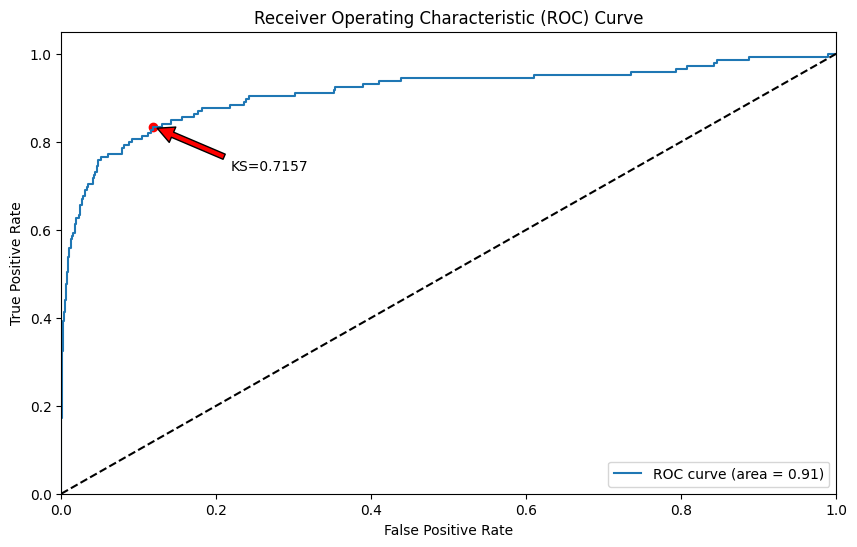

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Assuming y_test are your true labels and y_scores are the predicted probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_scores)
print(roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)  # Assuming you've calculated roc_auc elsewhere
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.scatter(fpr[ks_index], tpr[ks_index], color='red')  # KS statistic point

# Annotate the KS statistic on the plot
plt.annotate(f'KS={ks_statistic:.4f}', xy=(fpr[ks_index], tpr[ks_index]), xytext=(fpr[ks_index]+0.1, tpr[ks_index]-0.1),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
